In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install langdetect
!pip install tqdm
!pip install emoji


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langdetect import detect
import emoji
from emoji import is_emoji
import statsmodels.distributions.empirical_distribution
from tqdm import tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=1c1b672be25d19b0f25c3da5f931198f8ec3aabb48daa9ecb3b2df7395828ef3
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.9/457.9 kB 7.4 MB/s eta 0:00:00


## Initial Data Processing:

The preprocessing begins by loading train_data from data_supervised.csv and target from target_supervised.csv. Duplicate entries are removed to ensure data uniqueness, and indices are reset for both datasets. The final lines display a preview of train_data and target, confirming successful data loading and initial cleanup.


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Reddit/data_supervised.csv', encoding="utf8")
train_data = train_data.drop_duplicates()
train_data.reset_index(drop=True, inplace=True)

target = pd.read_csv("/content/drive/MyDrive/Reddit/target_supervised.csv")
target=target.drop_duplicates()
target.reset_index(drop=True,inplace=True)

print(train_data.tail())
print(target.head())



                  author     subreddit   created_utc  \
296030            Tashre    FiftyFifty  1.391213e+09   
296031  someguyfromtheuk     AskReddit  1.391213e+09   
296032       spurscanada         HIMYM  1.391213e+09   
296033           SPAZZEH      politics  1.391213e+09   
296034      whslaxattack  WorldofTanks  1.391213e+09   

                                                     body  
296030          I don't want to play this game anymore :(  
296031  Twist: I am your son and staged all of this to...  
296032  I think a lot of people don't like her because...  
296033  And the Tea Party must be having strokes right...  
296034  It has a huge ROF boost, so it is pretty much ...  
            author  gender
0     RedThunder90       0
1          Lirkmor       1
2           In0chi       0
3    ProjectGrudge       0
4  TehTurtleHermit       0


## Data Uniqueness and Completeness Analysis:

The dataset's diversity and completeness are assessed by calculating the number of unique values in key attributes: authors, subreddits, and comment bodies. Specifically, unique_authors, unique_subreddits, and unique_bodies are computed. Additionally, a check for missing data across all columns is performed using isnull().sum(). These statistics are crucial for understanding the dataset's breadth and ensuring data quality.


In [ ]:
# How many different attribute values you observe in each features? Is there any missing data?

unique_authors=train_data.author.unique().shape[0]
unique_subreddits=train_data.subreddit.unique().shape[0]
unique_bodies=train_data.body.unique().shape[0]
missing_data = train_data.isnull().sum()
print("Unique authors:", unique_authors)
print("Unique subreddits:", unique_subreddits)
print("Unique comment bodies:", unique_bodies)
print("\nMissing data in each column:\n", missing_data)

Unique authors: 5000
Unique subreddits: 3468
Unique comment bodies: 289608

Missing data in each column:
 author         0
subreddit      0
created_utc    0
body           0
dtype: int64


## Empirical Distribution of Comment Lengths:

The length of each comment is calculated, spaces excluded, to analyze the distribution of comment lengths in the dataset. The empirical cumulative distribution function (eCDF) is plotted for the log-transformed lengths, highlighting the quartiles. This analysis provides insights into the typical length of comments and their variability.

## Empirical Distribution of Number of Comments per Author:

The distribution of comments per author is analyzed by grouping the dataset by author. The number of comments for each author is log-transformed and visualized using the empirical cumulative distribution function (eCDF). This plot, with marked quartiles, helps to understand the typical engagement level of authors in the dataset.


## Gender Distribution in the Dataset:

To assess the balance of the dataset, the number of male and female authors is computed. A pie chart illustrates the proportion of each gender, indicating whether the dataset is gender-balanced, which is crucial for unbiased model training.


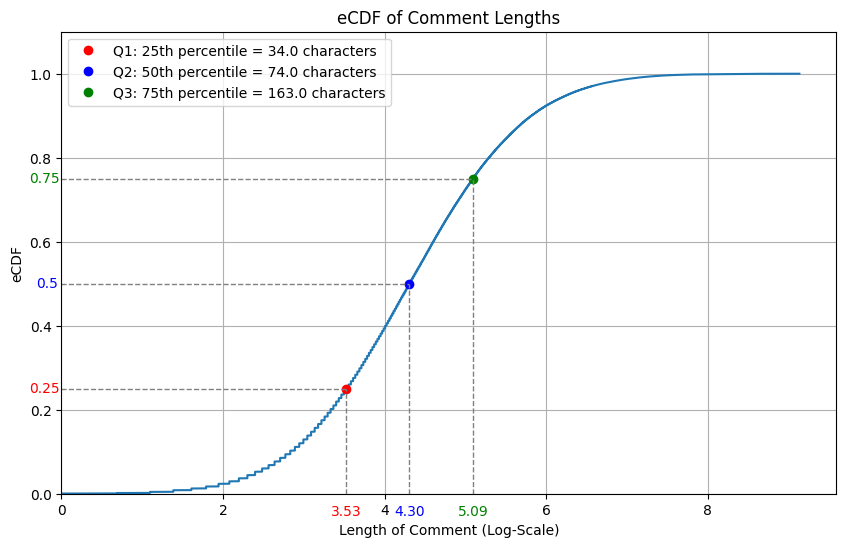

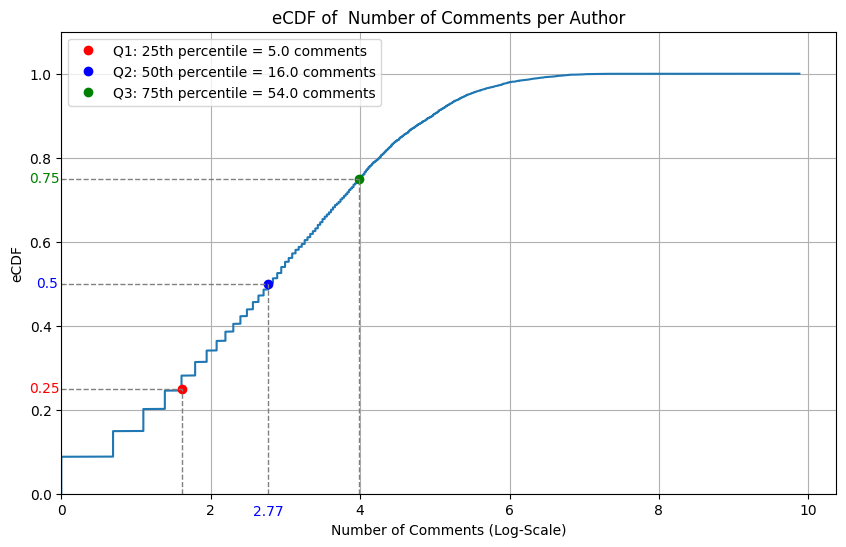

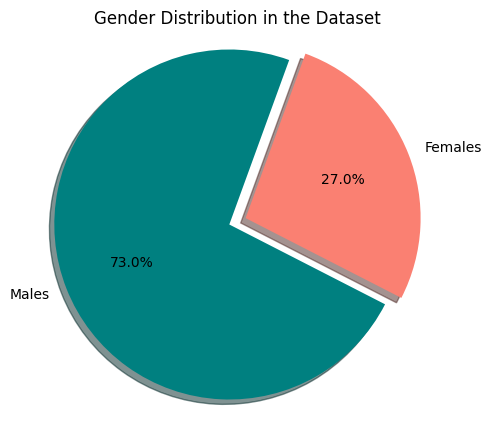

In [ ]:
# (Referring to textual features) How does the empirical distribution of the number of characters in
# each comment look like?
train_data['comment_length']=train_data['body'].str.replace(' ','').apply(len)
longest_comment = train_data['comment_length'].max()
log_comment_length = np.log(train_data['comment_length'])


ecdf = statsmodels.distributions.empirical_distribution.ECDF(log_comment_length)

plt.figure(figsize=(10, 6))
plt.plot(ecdf.x, ecdf.y)
plt.title('eCDF of Comment Lengths')
plt.xlabel('Length of Comment (Log-Scale)')
plt.ylabel('eCDF')

Q1 = np.interp(0.25, ecdf.y, ecdf.x)
Q2 = np.interp(0.5, ecdf.y, ecdf.x)
Q3 = np.interp(0.75, ecdf.y, ecdf.x)

point_label = f'Q1: 25th percentile = {round(np.exp(Q1),2)} characters'
plt.plot(Q1, 0.25, 'ro', label=point_label)
plt.plot([Q1, Q1], [0, 0.25], 'gray', linestyle='--',linewidth=1)
plt.plot([0, Q1], [0.25, 0.25], 'gray', linestyle='--',linewidth=1)
plt.annotate(f'{Q1:.2f}', (Q1, 0),
             textcoords="offset points", xytext=(0, -8), ha='center', va='top',color='red')
plt.annotate('0.25', xy=(0, 0.25), xytext=(-12, 0),
             textcoords="offset points", ha='center', va='center', color='red')

point_label = f'Q2: 50th percentile = {round(np.exp(Q2),2)} characters'
plt.plot(Q2, 0.5, 'bo', label=point_label)
plt.plot([Q2, Q2], [0, 0.5], 'gray', linestyle='--',linewidth=1)
plt.plot([0, Q2], [0.5, 0.5], 'gray', linestyle='--',linewidth=1)
plt.annotate(f'{Q2:.2f}', (Q2, 0),
             textcoords="offset points", xytext=(0, -8), ha='center', va='top',color='blue')
plt.annotate('0.5', xy=(0, 0.5), xytext=(-10, 0),
             textcoords="offset points", ha='center', va='center', color='blue')

point_label = f'Q3: 75th percentile = {round(np.exp(Q3),2)} characters'
plt.plot(Q3, 0.75, 'go', label=point_label)
plt.plot([Q3, Q3], [0, 0.75], 'gray', linestyle='--',linewidth=1)
plt.plot([0, Q3], [0.75, 0.75], 'gray', linestyle='--',linewidth=1)
plt.annotate(f'{Q3:.2f}', (Q3, 0),
             textcoords="offset points", xytext=(0, -8), ha='center', va='top',color='green')
plt.annotate('0.75', xy=(0, 0.75), xytext=(-12, 0),
             textcoords="offset points", ha='center', va='center', color='green')


plt.legend()
plt.xlim([0,None])
plt.ylim([0, 1.1])
plt.grid(True)
plt.show()

# How is the distribution of the number of comments per author?
comments_author=train_data.groupby('author').size()
log_comments_author=np.log(comments_author)

ecdf = statsmodels.distributions.empirical_distribution.ECDF(log_comments_author)


plt.figure(figsize=(10, 6))
plt.plot(ecdf.x, ecdf.y)
plt.title('eCDF of  Number of Comments per Author')
plt.xlabel('Number of Comments (Log-Scale)')
plt.ylabel('eCDF')

Q1 = np.interp(0.25, ecdf.y, ecdf.x)
Q2 = np.interp(0.5, ecdf.y, ecdf.x)
Q3 = np.interp(0.75, ecdf.y, ecdf.x)

point_label = f'Q1: 25th percentile = {round(np.exp(Q1),2)} comments'
plt.plot(Q1, 0.25, 'ro', label=point_label)
plt.plot([Q1, Q1], [0, 0.25], 'gray', linestyle='--',linewidth=1)
plt.plot([0, Q1], [0.25, 0.25], 'gray', linestyle='--',linewidth=1)

plt.annotate('0.25', xy=(0, 0.25), xytext=(-12, 0),
             textcoords="offset points", ha='center', va='center', color='red')

point_label = f'Q2: 50th percentile = {round(np.exp(Q2),2)} comments'
plt.plot(Q2, 0.5, 'bo', label=point_label)
plt.plot([Q2, Q2], [0, 0.5], 'gray', linestyle='--',linewidth=1)
plt.plot([0, Q2], [0.5, 0.5], 'gray', linestyle='--',linewidth=1)
plt.annotate(f'{Q2:.2f}', (Q2, 0),
             textcoords="offset points", xytext=(0, -8), ha='center', va='top',color='blue')
plt.annotate('0.5', xy=(0, 0.5), xytext=(-10, 0),
             textcoords="offset points", ha='center', va='center', color='blue')

point_label = f'Q3: 75th percentile = {round(np.exp(Q3),2)} comments'
plt.plot(Q3, 0.75, 'go', label=point_label)
plt.plot([Q3, Q3], [0, 0.75], 'gray', linestyle='--',linewidth=1)
plt.plot([0, Q3], [0.75, 0.75], 'gray', linestyle='--',linewidth=1)

plt.annotate('0.75', xy=(0, 0.75), xytext=(-12, 0),
             textcoords="offset points", ha='center', va='center', color='green')

plt.legend()
plt.xlim([0, None])
plt.ylim([0, 1.1])
plt.grid(True)
plt.show()


# Is the supervised dataset balanced between male and female?
num_males = (target['gender'] == 0).sum()
num_females = (target['gender'] == 1).sum()

#  plot
labels = 'Males', 'Females'
sizes = [num_males, num_females]
colors = ['teal', 'salmon']
explode = (0.1, 0)

plt.figure(figsize=(5, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=70)
plt.axis('equal')
plt.title('Gender Distribution in the Dataset')
plt.show()

## Language Distribution in Comments
To determine the language distribution in comments, each comment's language is identified using the detect() method from a language detection library.

After language detection, the number of English comments is compared against other languages and errors during detection. A pie chart visualizes this distribution, highlighting the predominance of English comments in the dataset. The data is then filtered to retain only English comments for subsequent analysis, ensuring language consistency in the analysis.



In [ ]:
#Are there only comments in English? usig googletrans wasnt efficient at all, it took 20 hrs so ifind out detect() method which takes only 20 minutes


languages=[]
errors_rows=[]
x = len(train_data['body'])
for i in tqdm(range(len(train_data['body']))):
    try:
        lang = detect(str(train_data['body'].iloc[i]))
    except Exception as e:
        lang = 'error'
        errors_rows.append(i)
    languages.append(lang)


100%|██████████| 296035/296035 [29:34<00:00, 166.80it/s]


In [ ]:
english_comments = languages.count('en')
total_comments = len(languages)

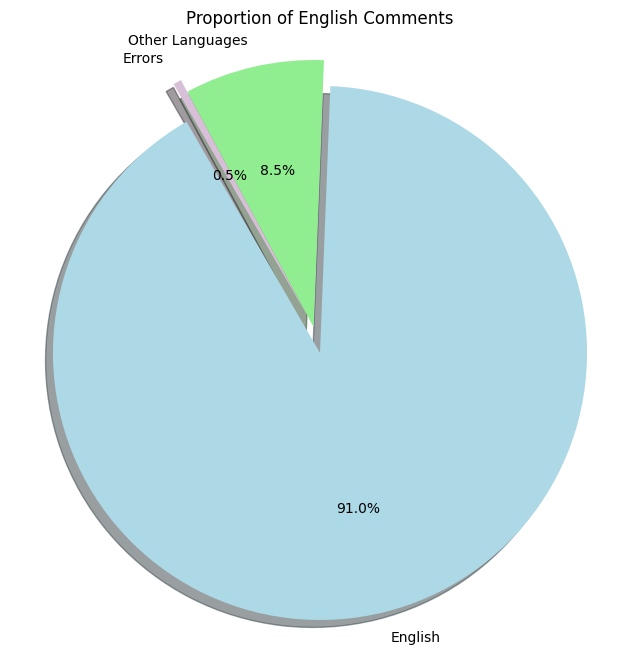

In [ ]:
labels = ['English', 'Other Languages','Errors']
sizes = [english_comments, total_comments - english_comments-len(errors_rows),len(errors_rows)]
colors = ['lightblue', 'lightgreen','thistle']
explode = (0.1, 0,0.05)  # only "explode" the 1st slice (i.e., 'English')

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=120)
plt.axis('equal')
plt.title('Proportion of English Comments')
plt.show()

In [ ]:
train_data['language'] = languages
train_data_en = train_data[train_data['language'] == 'en']


## Text Data Preprocessing and Vectorization
Text data from comments is first preprocessed by converting to lowercase and removing stop words and lemmatizing using spaCy's English model. This streamlines the dataset, focusing on meaningful content. Each author's comments are then concatenated, capturing their unique linguistic style. For feature extraction, two vectorization techniques are applied: Bag of Words (BoW) using CountVectorizer for frequency analysis, and TF-IDF using TfidfVectorizer with a min_df parameter for weighting words based on their importance. These steps transform text data into structured formats for subsequent analysis.

In [ ]:
train_data_en['body'] = train_data_en['body'].str.lower()
train_data_en

<ipython-input-10-4fbfca80c962>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_en['body'] = train_data_en['body'].str.lower()


,author,subreddit,created_utc,body,comment_length,language
0,Shamus_Aran,mylittlepony,1.388534e+09,i don't think we'd get nearly as much fanficti...,85,en
1,Riddance,sex,1.388534e+09,"thanks. i made it up, that's how i got over my...",52,en
2,Secret_Wizard,DragonsDogma,1.388534e+09,are you sure you aren't confusing cyclops (the...,286,en
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro,17,en
4,7-SE7EN-7,todayilearned,1.388534e+09,that's what we do when we can't find a mate,34,en
...,...,...,...,...,...,...
296030,Tashre,FiftyFifty,1.391213e+09,i don't want to play this game anymore :(,33,en
296031,someguyfromtheuk,AskReddit,1.391213e+09,twist: i am your son and staged all of this to...,107,en
296032,spurscanada,HIMYM,1.391213e+09,i think a lot of people don't like her because...,103,en
296033,SPAZZEH,politics,1.391213e+09,and the tea party must be having strokes right...,41,en


In [ ]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy import sparse
from sklearn.utils import shuffle

# Load spaCy's English language model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function to preprocess text: remove stop words and lemmatize
def preprocess_text(texts):
    processed_texts = []
    for doc in nlp.pipe(texts):
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        processed_texts.append(' '.join(tokens))
    return processed_texts

# Preprocess the commentss
train_data_en['body'] = preprocess_text(train_data_en['body'])

<ipython-input-11-93b42e9dd75b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_en['body'] = preprocess_text(train_data_en['body'])


In [ ]:
# Function to concatenate comments of a single author
# This function joins all comments made by an individual author into a single continuous text.
# This concatenated text is used for text-based feature extraction like Bag of Words or TF-IDF.
def extract_text(group):
    group_text = group['body'].values
    return " ".join(group_text)

# Creating a dictionary of concatenated texts for each author
# The training data is grouped by author, and their comments are concatenated.
# This results in a dictionary where each author is mapped to their combined text.
text_dict = {}
for author, group in train_data.groupby('author'):
    text_dict[author] = extract_text(group)

# Preparing text data for vectorization
# We create a list of concatenated texts, one for each author in the target dataset.
# This list is used to transform the text data into numerical features.
author_text = [text_dict[author] for author in target.author]

In [ ]:
# Text Vectorization using Bag of Words (BoW)
# The CountVectorizer is used to convert the concatenated texts into a BoW model.
# This model represents the frequency of each word's occurrence in each author's text.
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(author_text)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#  TfidfVectorizer with min_df where  min_df represents the minimum frequency threshold for a word to be included based on its occurrence across the comments.
vectorizer = TfidfVectorizer(min_df=5)
X_tfidf = vectorizer.fit_transform(author_text)

In [ ]:
#This snippet was for exploring scaling before dimentionality reduction
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_tfidf)

## Balancing the Dataset with SMOTE
To address class imbalance, we apply SMOTE (Synthetic Minority Over-sampling Technique). This method generates synthetic samples for the minority class, leading to a balanced dataset with equal representation of both genders.

In [ ]:
#creating a balanced set using SMOTE
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_tfidf, target['gender'])

In [ ]:
print(X_smote.shape)


(7302, 33002)



## Dimensionality Reduction with Truncated SVD:

To manage the high dimensionality of the feature set, Truncated Singular Value Decomposition (SVD) is employed. This technique is particularly suited for sparse matrices like the one obtained from our TF-IDF and subreddit features. Truncated SVD is initialized with 1000 components, aiming to reduce the feature space while retaining as much of the data's variance as possible. Post reduction, the cumulative explained variance is calculated and outputted, offering a quantitative measure of the information preserved in the reduced dataset. This variance metric assists in evaluating the adequacy of the dimensionality reduction.


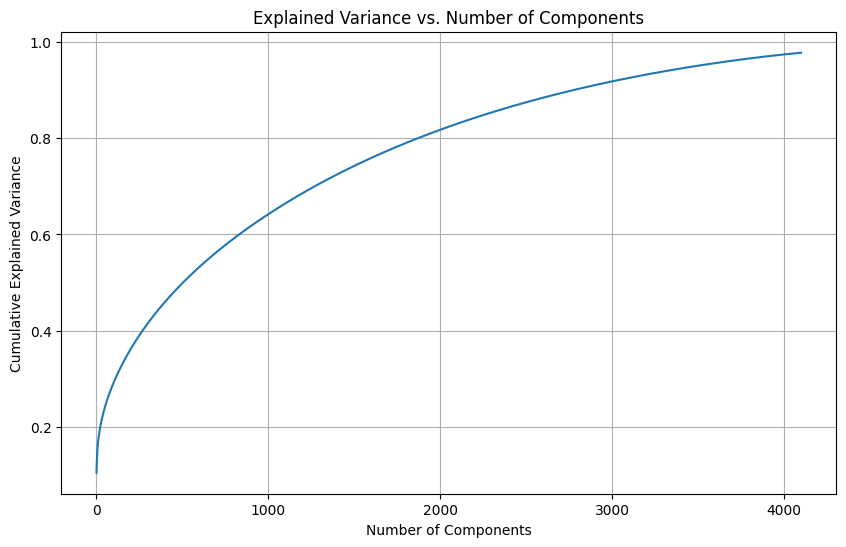

In [ ]:

from sklearn.decomposition import TruncatedSVD




n_components=4100

svd = TruncatedSVD(n_components=4100)
X_reduced = svd.fit_transform(X_smote)
explained_variances = svd.explained_variance_ratio_


# Plotting the curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), explained_variances.cumsum(), marker=None)
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [ ]:


n_components = 3000
svd = TruncatedSVD(n_components=n_components)
X_reduced = svd.fit_transform(X_smote)
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Cumulative explained variance for {n_components} components: {explained_variance}")


Cumulative explained variance for 3000 components: 0.9169237543547066


In [ ]:

#  we have tried exploring post-dimensionality reduction scaling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_smote, test_size=0.3, random_state=42)

# Standardizing the data for models sensitive to feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled=scaler.transform(X_reduced)

models = {
    "Logistic Regression": LogisticRegression(),
    "Logistic Regression (Scaled)": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "SVM (Scaled)": SVC()
}

n_folds = 10
cv = StratifiedKFold(n_splits=n_folds)

# Training, evaluating, and applying k-fold CV to each model
for name, model in models.items():
    # Selecting training set
    if "Scaled" in name:
        X_train_selected = X_train_scaled
        X_test_selected = X_test_scaled
    else:
        X_train_selected = X_train
        X_test_selected = X_test

    # Train model
    model.fit(X_train_selected, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)

    # Evaluating accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Model: {name}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print("Classification Report:\n", classification_report(y_test, y_test_pred))

    # K-fold Cross-validation
    cv_data = X_scaled if "Scaled" in name else X_reduced
    cv_scores = cross_val_score(model, cv_data, y_smote, cv=cv)
    print(f"Cross-Validation Scores ({n_folds} folds): {cv_scores}")
    print(f"Average CV Score: {np.mean(cv_scores):.4f}")
    print("-" * 50)


Model: Logistic Regression
Training Accuracy: 0.8836
Test Accuracy: 0.8435
Confusion Matrix:
 [[965 139]
 [204 883]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1104
           1       0.86      0.81      0.84      1087

    accuracy                           0.84      2191
   macro avg       0.84      0.84      0.84      2191
weighted avg       0.84      0.84      0.84      2191

Cross-Validation Scores (10 folds): [0.7619699  0.78659371 0.77945205 0.83287671 0.90136986 0.88356164
 0.88356164 0.89315068 0.89315068 0.89589041]
Average CV Score: 0.8512
--------------------------------------------------
Model: Logistic Regression (Scaled)
Training Accuracy: 1.0000
Test Accuracy: 0.8403
Confusion Matrix:
 [[843 261]
 [ 89 998]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.76      0.83      1104
           1       0.79      0.92      0.85     

In [30]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
import seaborn as sns

# Split the dataset into training (70%) and testing (30%) sets.
# This is done to evaluate the model's performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_smote, test_size=0.3, random_state=42)

# Further split the training set for grid search purposes (50% of the training set).
# We used this for to efficiently tune hyperparameters without overly extensive computation.
# It ensures a significant enough sample for grid search while keeping the computational cost manageable.
# Additionally, this keeps the test set untouched, allowing for unbiased final model evaluation.
X_train_gs, _, y_train_gs, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Initialize models and set up their respective grid search parameters.
# Grid search parameters are chosen to explore a range of potential values
# for each model's key hyperparameters.
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}

param_grid = {
    "Logistic Regression": {
        'C': np.logspace(0, 4, 20),  # Regularization strength
        'solver': ['liblinear'],     # Algorithm for optimization
        'max_iter': [100,500, 1000]            # Maximum iterations for convergence
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300],  # Number of trees
        "max_depth": [10, 20, 30, None],  # Maximum depth of trees
        "min_samples_split": [2, 5, 10]   # Minimum samples required to split a node
    },
    "SVM": {
        "C": np.logspace(-2, 2, 5),   # Regularization parameter
        "gamma": ['scale', 'auto'],   # Kernel coefficient
        "kernel": ['rbf', 'linear']   # Specifies the kernel type
    }
}

# Training, evaluating, and tuning each model using grid search on the subset.
# Grid search is used to systematically work through multiple combinations
# of parameter tunes, cross-validating as it goes to determine
# which tune gives the best performance.
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy', return_train_score=True)
    grid_search.fit(X_train_gs, y_train_gs)

    # Extract the best parameters and model from the grid search
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Train the best model on the full training dataset.
    best_model.fit(X_train, y_train)

    # Make predictions on both training and testing sets.
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Evaluate the model's performance.
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

    # Print the model's performance metrics.
    print(f"Model: {name}")
    print(f"Best Parameters from Grid Search: {best_params}")
    print(f"Train Accuracy on Full Data: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print("Classification Report:\n", classification_report(y_test, y_test_pred))
    print("-" * 50)


Model: Logistic Regression
Best Parameters from Grid Search: {'C': 127.42749857031335, 'max_iter': 100, 'solver': 'liblinear'}
Train Accuracy on Full Data: 0.9992
Test Accuracy: 0.8918
Test AUC: 0.9523
Confusion Matrix:
 [[960 144]
 [ 93 994]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1104
           1       0.87      0.91      0.89      1087

    accuracy                           0.89      2191
   macro avg       0.89      0.89      0.89      2191
weighted avg       0.89      0.89      0.89      2191

--------------------------------------------------
Model: Random Forest
Best Parameters from Grid Search: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Train Accuracy on Full Data: 0.9658
Test Accuracy: 0.8247
Test AUC: 0.8930
Confusion Matrix:
 [[960 144]
 [240 847]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0

In [31]:

from sklearn.metrics import roc_auc_score



X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_smote, test_size=0.3, random_state=42)


rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 4, 10],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}


rf = RandomForestClassifier(random_state=42)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(rf, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)


best_rf = grid_search.best_estimator_

# Train the best model
best_rf.fit(X_train, y_train)

# Evaluate on the test set
y_test_pred_proba = best_rf.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print("Best Random Forest Parameters:", grid_search.best_params_)
print("Best CV AUC Score:", grid_search.best_score_)
print("Test AUC Score:", test_auc)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Random Forest Parameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best CV AUC Score: 0.9204042798738092
Test AUC Score: 0.91568128941509
